Adaptive NVAR Model \
Author: Azimov Sherkhon \
Email: sherxonazimov94@pusan.ac.kr \
Date: May 2025 \
Description: a jointly trained adaptive NVAR model that combines delay-
embedded linear inputs with features generated by a shallow, learnable Multi-Layer Perceptron
(MLP). We employ a unified training strategy where both the MLP and linear readout are optimized
simultaneously using gradient-based methods.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.model_selection import train_test_split
import warnings
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device in use: {device}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.current_device()} - {torch.cuda.get_device_name(0)}")

Device in use: cuda
CUDA device: 0 - NVIDIA GeForce RTX 3060


In [2]:
# ---------------------------
# Configuration & Constants
# ---------------------------
s = 4 # observation frequency
dt = 0.025
maxtime = 100

maxtime_pts = int(maxtime / dt)  # 400 steps of 0.25
t_eval = np.linspace(0, maxtime, maxtime_pts + 1)  # 401 time points


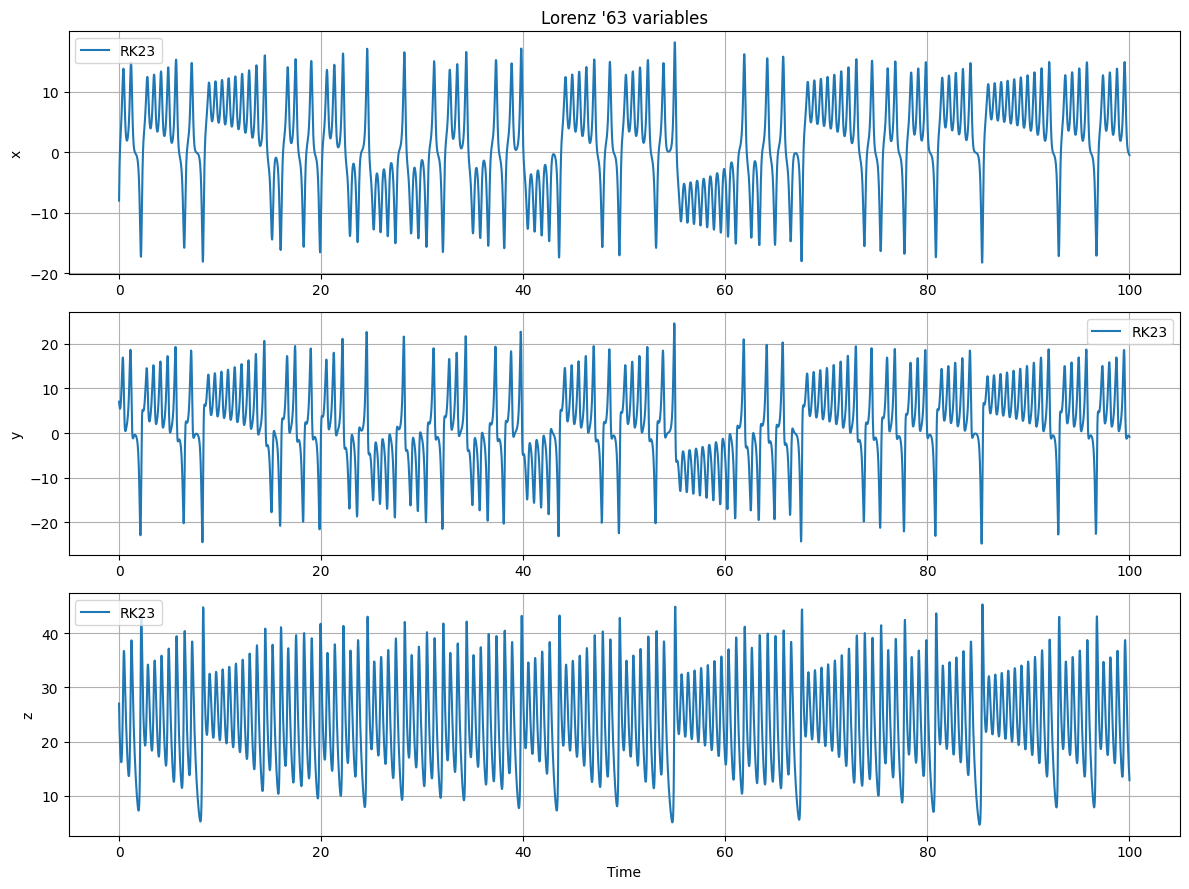

In [3]:
# ---------------------------
# Lorenz '63 System
# ---------------------------
lorenz_rk23 = np.load("ground_truth.npy")
Lorenz63data = lorenz_rk23.T

# ---------------------------
# Visualization
# ---------------------------
variables = ['x', 'y', 'z']
plt.figure(figsize=(12, 9))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(t_eval, lorenz_rk23[i], label='RK23', color='C0')
    plt.ylabel(variables[i])
    plt.grid(True)
    if i == 0:
        plt.title("Lorenz '63 variables")
    if i == 2:
        plt.xlabel('Time')
    plt.legend()
plt.tight_layout()
plt.show()

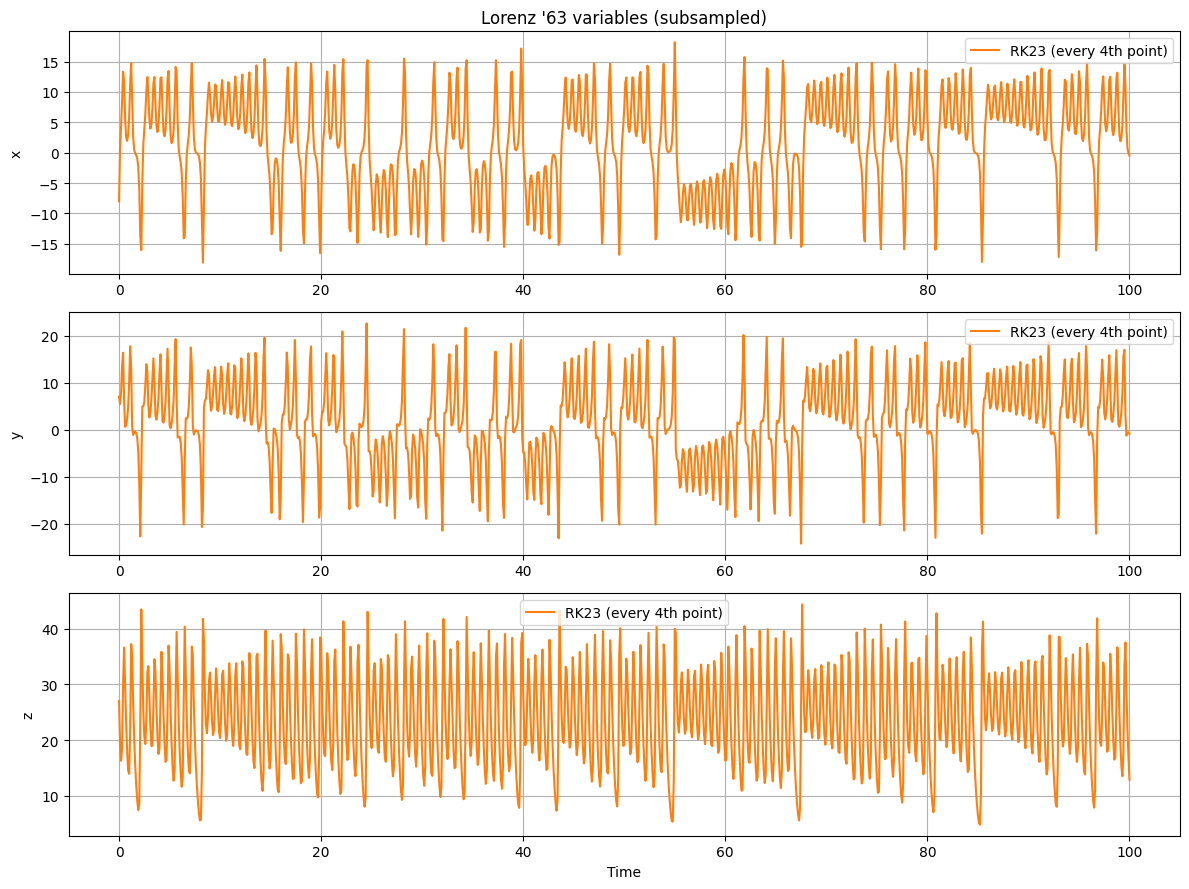

In [4]:
# Choose every 4th time step
t_eval = t_eval[::s]
lorenz_rk23 = lorenz_rk23[:, ::s]  # shape still (3, time), but fewer points
Lorenz63data = Lorenz63data[::s, :]
# ---------------------------
# Visualization (subsampled)
# ---------------------------
variables = ['x', 'y', 'z']
plt.figure(figsize=(12, 9))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(t_eval, lorenz_rk23[i], label='RK23 (every 4th point)', color='C1')
    plt.ylabel(variables[i])
    plt.grid(True)
    if i == 0:
        plt.title("Lorenz '63 variables (subsampled)")
    if i == 2:
        plt.xlabel('Time')
    plt.legend()
plt.tight_layout()
plt.show()

In [5]:
Lorenz63data.shape

(1001, 3)

In [6]:
# Set seeds
seed = 2025
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ---------------------------
# Noise Addition
# ---------------------------
def add_relative_gaussian_noise(X_clean, noise_scale):
    signal_std = np.std(X_clean, axis=0)
    noise = np.random.normal(loc=0.0, scale=noise_scale * signal_std, size=X_clean.shape)
    return X_clean + noise

X_noisy = add_relative_gaussian_noise(Lorenz63data, noise_scale=0.10) # Moderate case: 10% noise
X = torch.tensor(X_noisy, dtype=torch.float32)
X_true = torch.tensor(Lorenz63data, dtype=torch.float32)

In [7]:
# ---------------------------
# Dataset Splitting
# ---------------------------
T_total = X.shape[0]
warmup_len = 50
train_len = 400
test_len = 25

X_warmup = X[:warmup_len].to(device)
X_train = X[warmup_len:warmup_len + train_len].to(device)
X_test = X[warmup_len + train_len:warmup_len + train_len + test_len].to(device)
X_test_true = X_true[warmup_len + train_len:warmup_len + train_len + test_len].to(device)

In [8]:
# ---------------------------
# Model Definitions
# ---------------------------
d = 3
k = 8
dk = d * k
m = int((dk * (dk + 1)) / 2)

class FeatureMLP(nn.Module):
    def __init__(self, input_dimension=dk, hidden_dimension=2000, output_dimension=m):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dimension, hidden_dimension),
            nn.Tanh(),
            nn.Dropout(0.10),
            nn.Linear(hidden_dimension, output_dimension)
        )

    def forward(self, x):
        return self.net(x)

class AdaptiveNVARModel(nn.Module):
    def __init__(self, dk, m, d):
        super().__init__()
        self.mlp = FeatureMLP(input_dimension=dk, output_dimension=m)
        self.readout = nn.Linear(dk + m, d, bias=False)

    def forward(self, H_lin):
        H_nn = self.mlp(H_lin)
        H_total = torch.cat([H_lin, H_nn], dim=1)
        return self.readout(H_total)

In [9]:
# ---------------------------
# Delay Embedding
# ---------------------------
def construct_H_lin(X, k):
    T = X.shape[0]
    return torch.cat([X[i:T - k + i] for i in range(k)], dim=1)

# ---------------------------
# Training Loop
# ---------------------------
def train_joint_model_with_lbfgs(X, k, m, num_epochs_adam=2000, num_epochs_lbfgs=5000,
                                 save_path="best_joint_model_10percent_noise_obs4.pth",  patience=50, tolerance=1e-9):
    X = X.to(device)
    H_lin = construct_H_lin(X, k)                 # [n, dk]
    Y = X[k:] - X[k - 1:-1]                       # [n, d]
    n, dk = H_lin.shape
    d = Y.shape[1]

    model = AdaptiveNVARModel(dk=dk, m=m, d=d).to(device)

    # --- Phase 1: Train with Adam
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr_adam, weight_decay=weight_decay)
    optimizer = torch.optim.Adam(model.parameters(),
    lr=0.001,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0,
    amsgrad=False,
    foreach=None,
    capturable=False,
    differentiable=False,
    fused=None
     )

    for epoch in range(num_epochs_adam):
        model.train()
        Y_hat = model(H_lin)
        loss = F.mse_loss(Y_hat, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 1000 == 0 or epoch == num_epochs_adam - 1:
            print(f"[Adam] Epoch {epoch:3d} | Loss: {loss.item():.4e}")

    # Save Adam-trained model state before L-BFGS
    torch.save(model.state_dict(), save_path)

    # --- Phase 2: Fine-tune with L-BFGS
    model.load_state_dict(torch.load(save_path))
    #optimizer = torch.optim.LBFGS(model.parameters(), lr=1.0, max_iter=20, tolerance_grad=1e-10, tolerance_change=1e-12, history_size=10, line_search_fn="strong_wolfe")
    #optimizer = torch.optim.LBFGS(model.parameters(), lr=1.0)
    optimizer = torch.optim.LBFGS(
    model.parameters(),
    lr=1.0,
    max_iter=20,
    max_eval=None,
    tolerance_grad=1e-6,
    tolerance_change=1e-10,
    history_size=20,
    line_search_fn=None
     )

    best_loss = float('inf')
    epochs_no_improve = 0

    def closure():
        optimizer.zero_grad()
        Y_hat = model(H_lin)
        loss = F.mse_loss(Y_hat, Y)
        loss.backward()
        return loss

    for epoch in range(num_epochs_lbfgs):
        model.train()
        loss = optimizer.step(closure)
        current_loss = loss.item()

        if epoch % 100 == 0 or epoch == num_epochs_lbfgs - 1:
            print(f"[L-BFGS] Epoch {epoch:3d} | Loss: {current_loss:.4e}")

        # Early stopping logic
        if best_loss - current_loss > tolerance:
            best_loss = current_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

    # Save final model
    torch.save(model.state_dict(), save_path)
    print("Final model saved after L-BFGS fine-tuning.")
    return model

[Adam] Epoch   0 | Loss: 4.3910e+01
[Adam] Epoch 1000 | Loss: 3.9444e-01
[Adam] Epoch 1999 | Loss: 3.0771e-01
[L-BFGS] Epoch   0 | Loss: 3.0080e-01
[L-BFGS] Epoch 100 | Loss: 2.5096e-01
Early stopping triggered at epoch 108
Final model saved after L-BFGS fine-tuning.


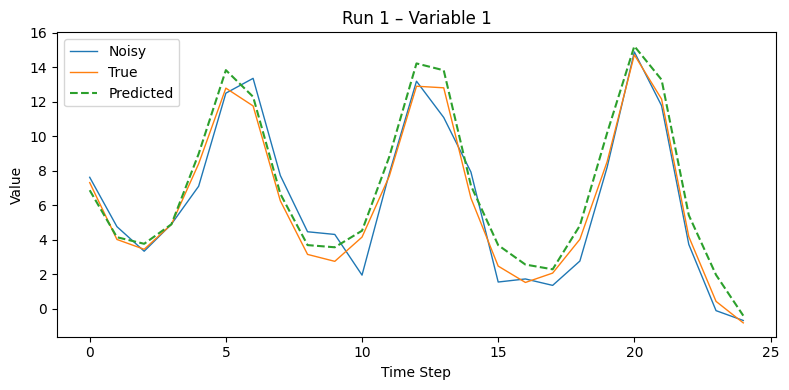

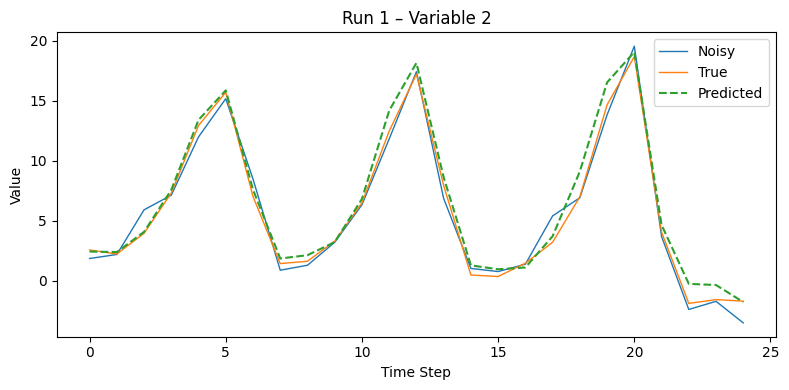

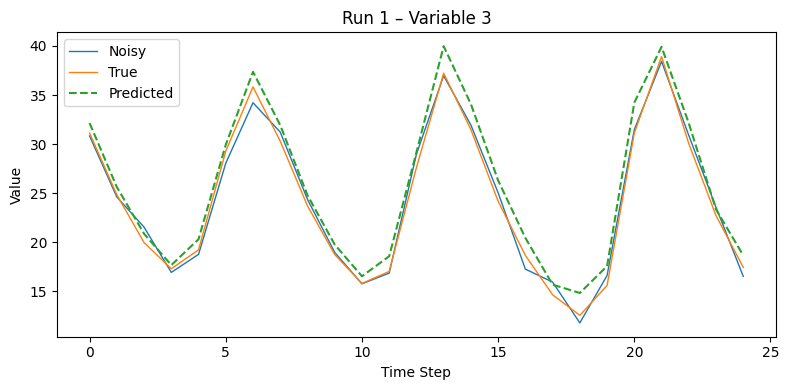

[Adam] Epoch   0 | Loss: 4.6572e+01
[Adam] Epoch 1000 | Loss: 4.3558e-01
[Adam] Epoch 1999 | Loss: 3.0806e-01
[L-BFGS] Epoch   0 | Loss: 3.0583e-01
[L-BFGS] Epoch 100 | Loss: 2.7561e-01
Early stopping triggered at epoch 125
Final model saved after L-BFGS fine-tuning.


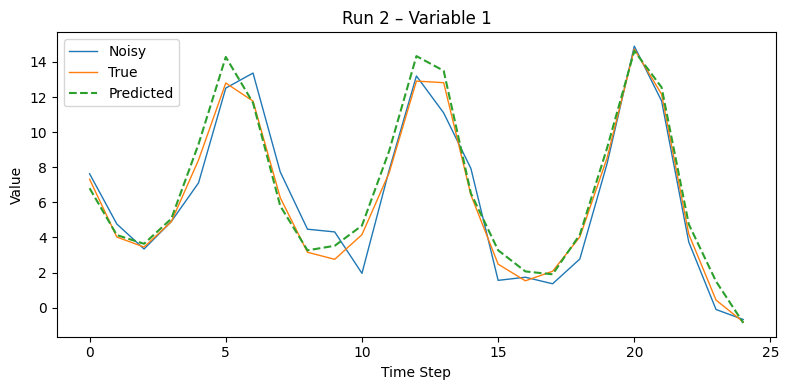

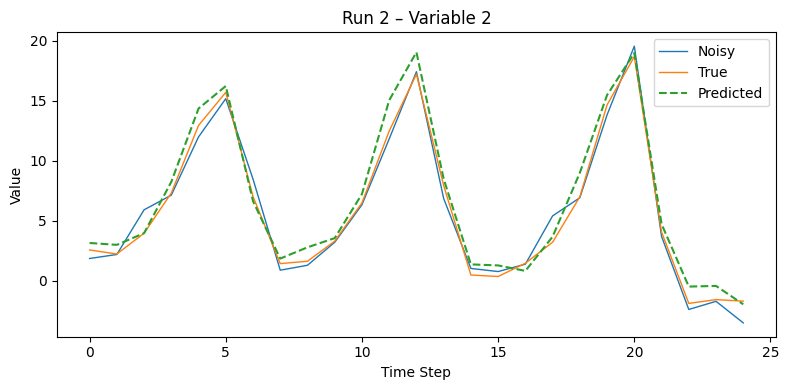

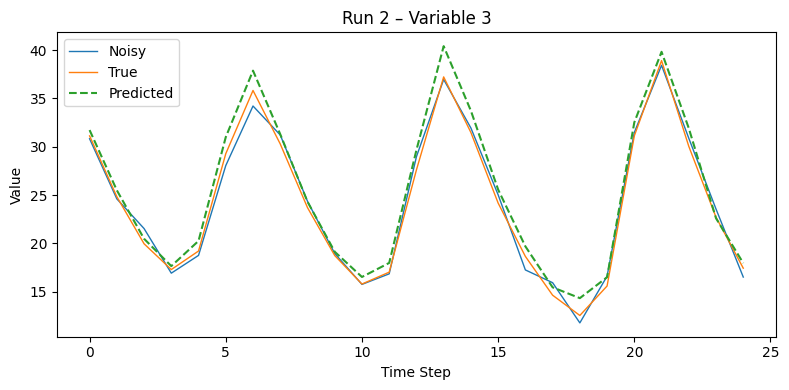

[Adam] Epoch   0 | Loss: 4.3529e+01
[Adam] Epoch 1000 | Loss: 3.9374e-01
[Adam] Epoch 1999 | Loss: 2.9057e-01
[L-BFGS] Epoch   0 | Loss: 2.8685e-01
[L-BFGS] Epoch 100 | Loss: 2.7482e-01
Early stopping triggered at epoch 140
Final model saved after L-BFGS fine-tuning.


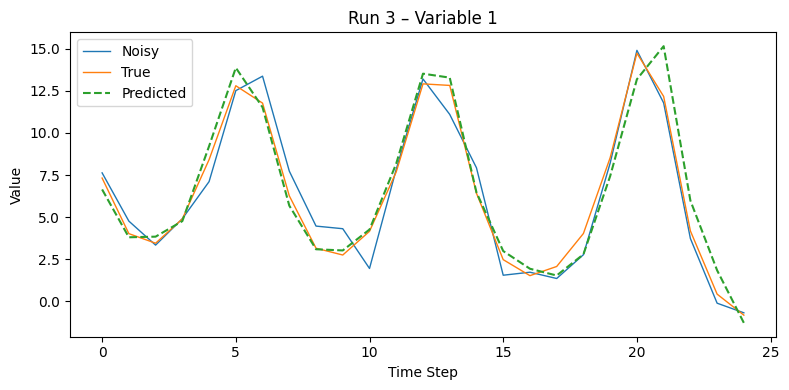

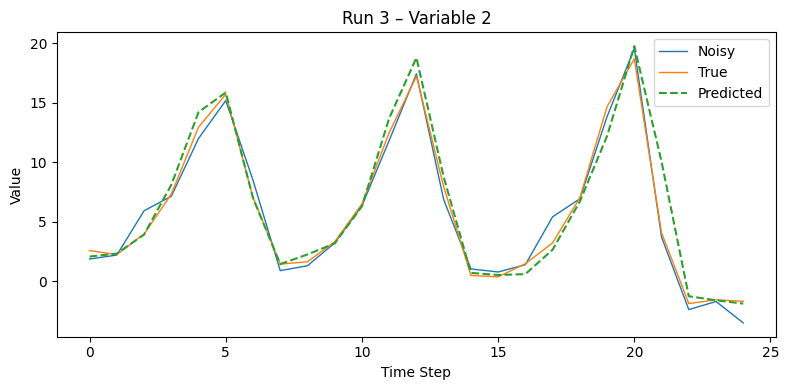

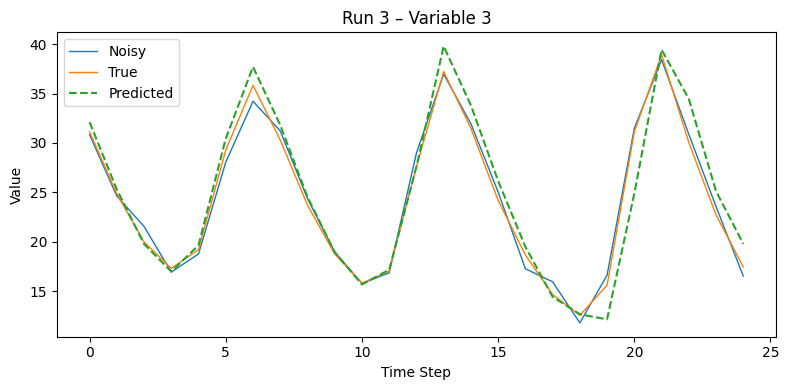

[Adam] Epoch   0 | Loss: 4.1025e+01
[Adam] Epoch 1000 | Loss: 3.8106e-01
[Adam] Epoch 1999 | Loss: 2.8813e-01
[L-BFGS] Epoch   0 | Loss: 2.8282e-01
Early stopping triggered at epoch 88
Final model saved after L-BFGS fine-tuning.


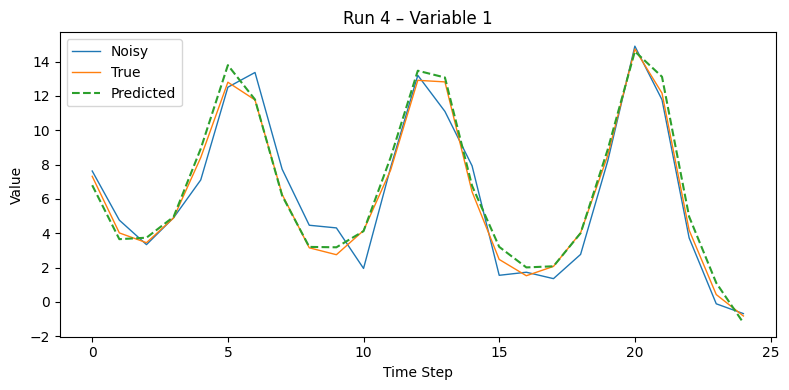

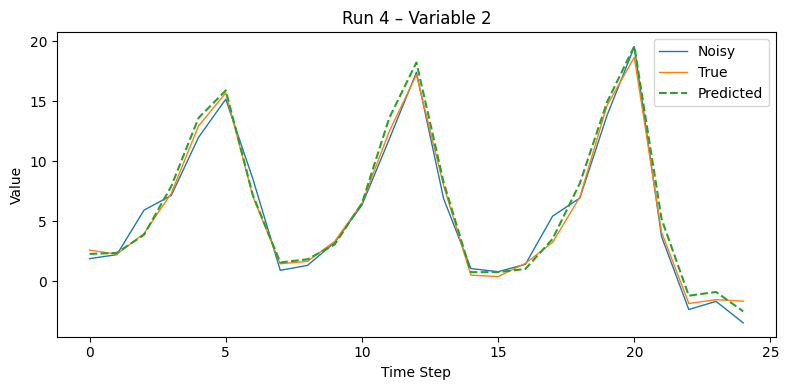

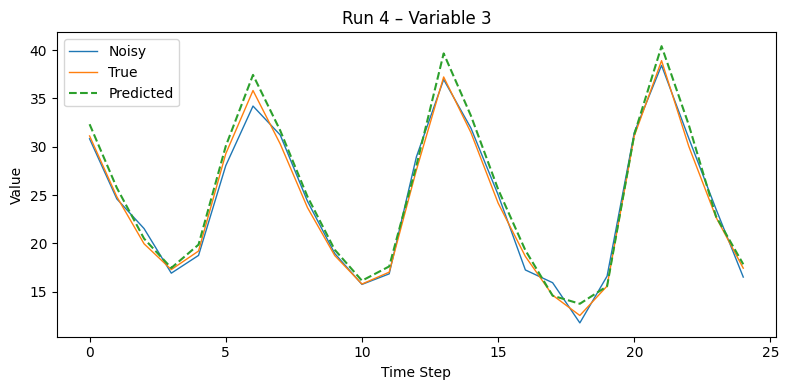

[Adam] Epoch   0 | Loss: 4.0460e+01
[Adam] Epoch 1000 | Loss: 3.7207e-01
[Adam] Epoch 1999 | Loss: 3.1298e-01
[L-BFGS] Epoch   0 | Loss: 2.8365e-01
Early stopping triggered at epoch 67
Final model saved after L-BFGS fine-tuning.


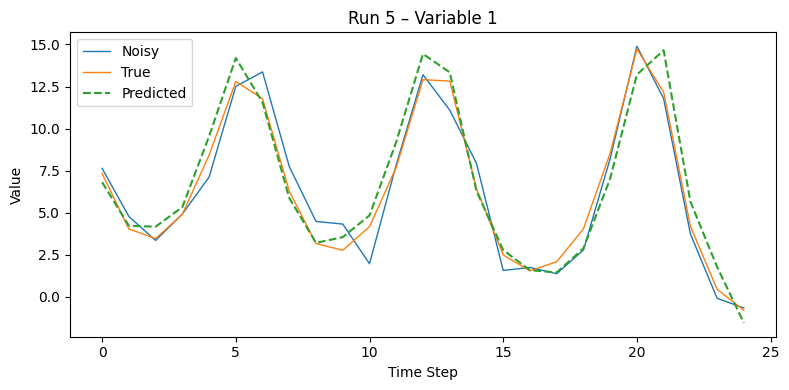

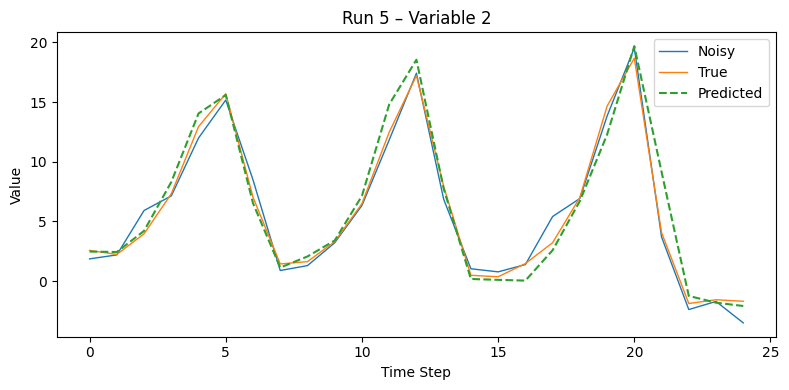

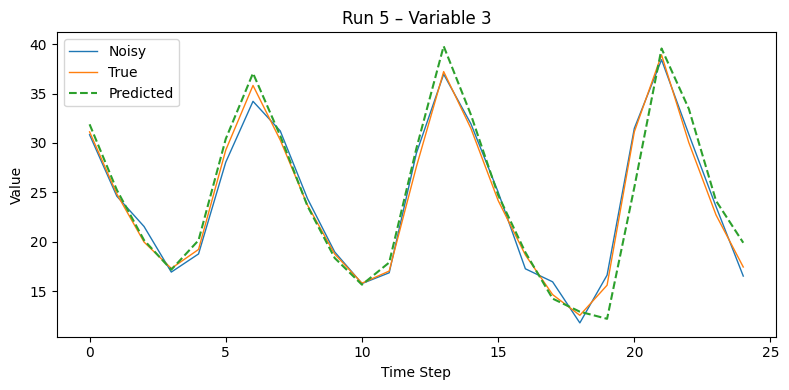

[Adam] Epoch   0 | Loss: 4.0058e+01
[Adam] Epoch 1000 | Loss: 3.6165e-01
[Adam] Epoch 1999 | Loss: 3.2540e-01
[L-BFGS] Epoch   0 | Loss: 3.2493e-01
Early stopping triggered at epoch 82
Final model saved after L-BFGS fine-tuning.


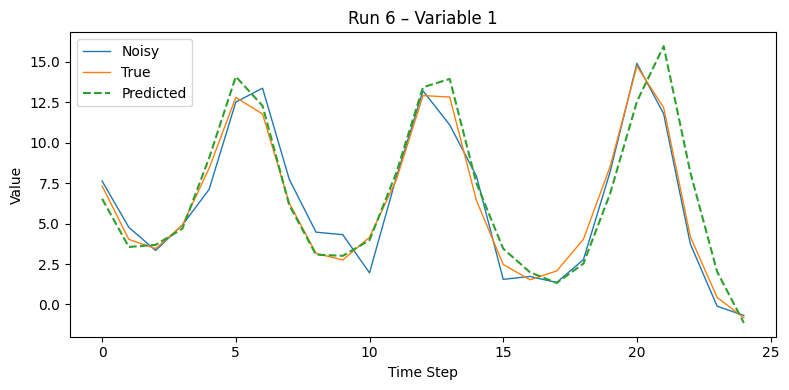

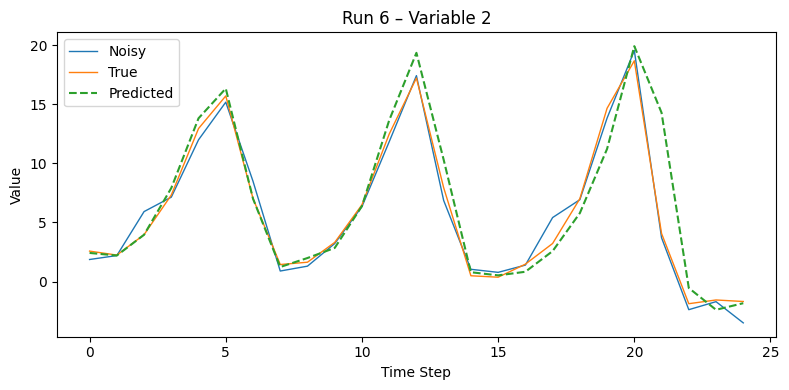

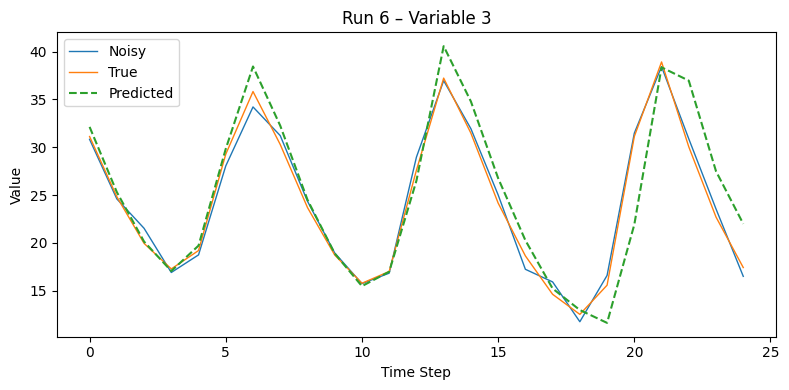

[Adam] Epoch   0 | Loss: 4.6179e+01
[Adam] Epoch 1000 | Loss: 3.8714e-01
[Adam] Epoch 1999 | Loss: 3.1160e-01
[L-BFGS] Epoch   0 | Loss: 2.8809e-01
Early stopping triggered at epoch 97
Final model saved after L-BFGS fine-tuning.


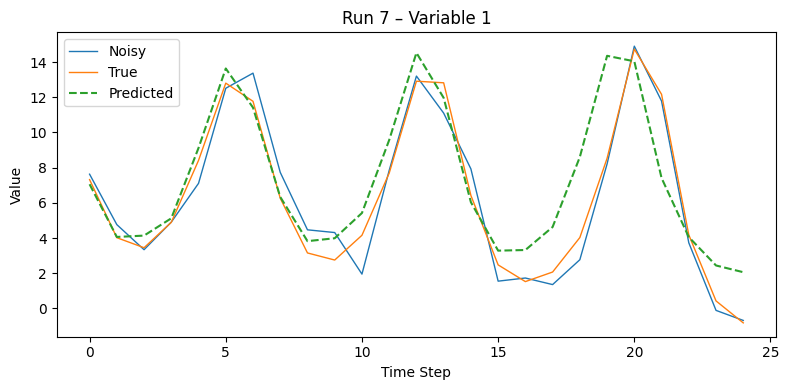

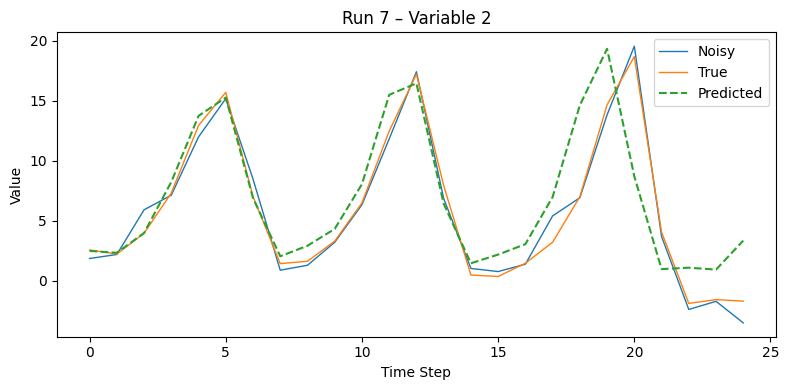

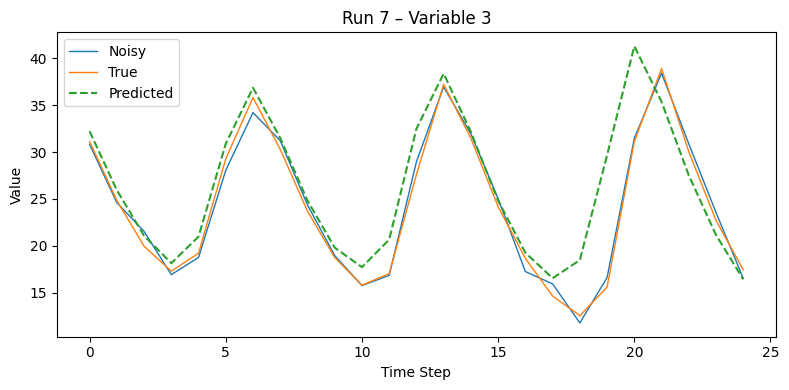

[Adam] Epoch   0 | Loss: 3.9707e+01
[Adam] Epoch 1000 | Loss: 3.3619e-01
[Adam] Epoch 1999 | Loss: 3.0657e-01
[L-BFGS] Epoch   0 | Loss: 3.0970e-01
[L-BFGS] Epoch 100 | Loss: 2.3420e-01
Early stopping triggered at epoch 103
Final model saved after L-BFGS fine-tuning.


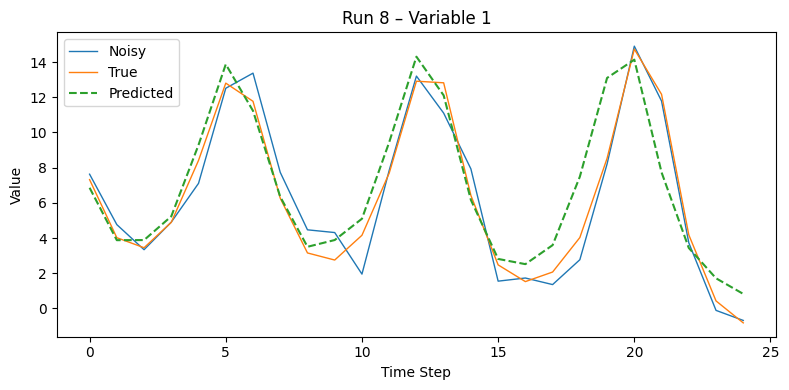

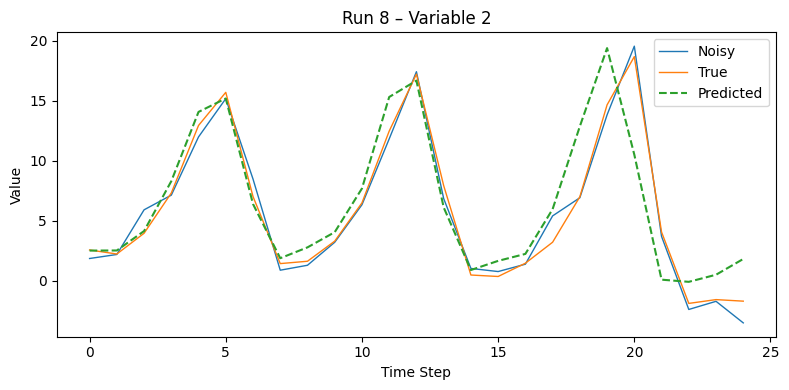

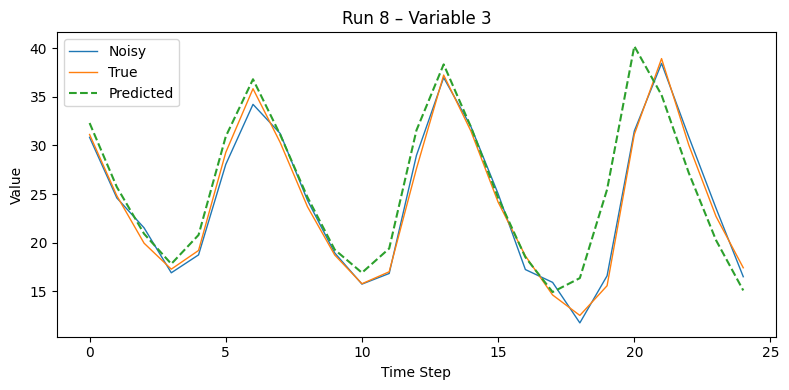

[Adam] Epoch   0 | Loss: 3.9811e+01
[Adam] Epoch 1000 | Loss: 3.8861e-01
[Adam] Epoch 1999 | Loss: 2.7621e-01
[L-BFGS] Epoch   0 | Loss: 2.9564e-01
Early stopping triggered at epoch 82
Final model saved after L-BFGS fine-tuning.


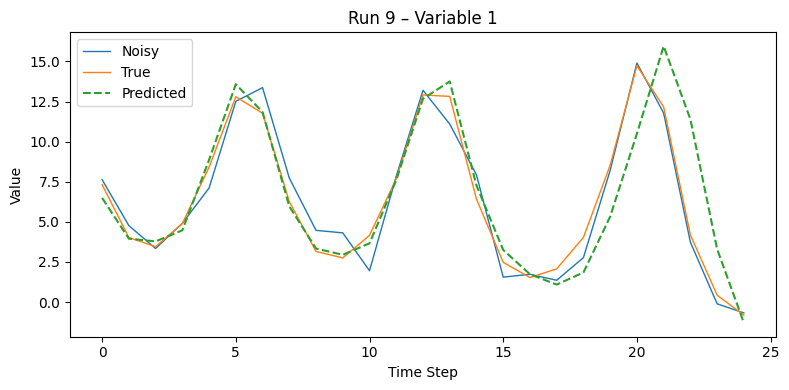

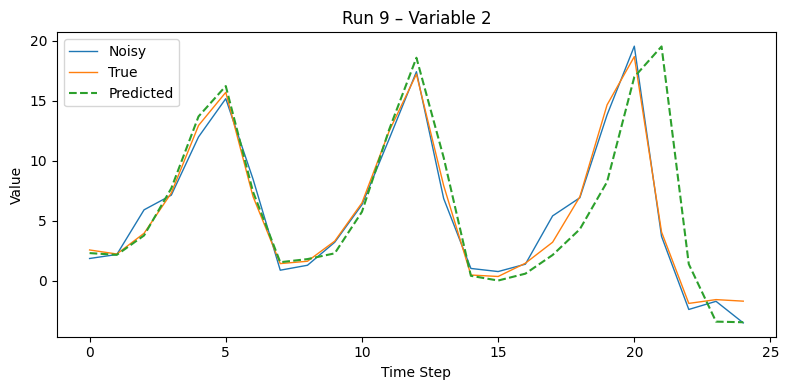

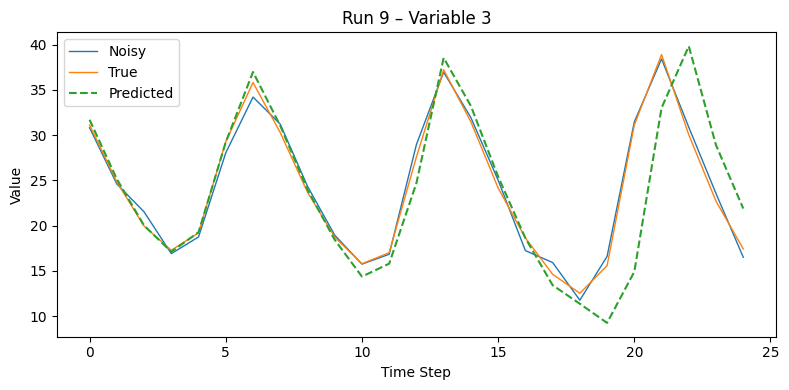

[Adam] Epoch   0 | Loss: 3.9220e+01
[Adam] Epoch 1000 | Loss: 4.1089e-01
[Adam] Epoch 1999 | Loss: 2.9366e-01
[L-BFGS] Epoch   0 | Loss: 3.2087e-01
[L-BFGS] Epoch 100 | Loss: 2.3898e-01
Early stopping triggered at epoch 105
Final model saved after L-BFGS fine-tuning.


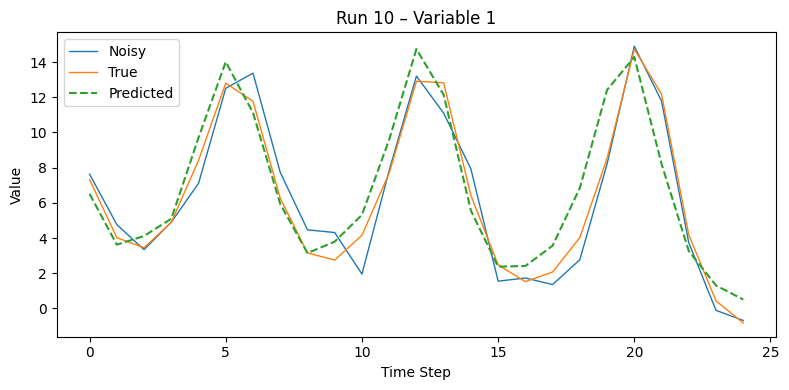

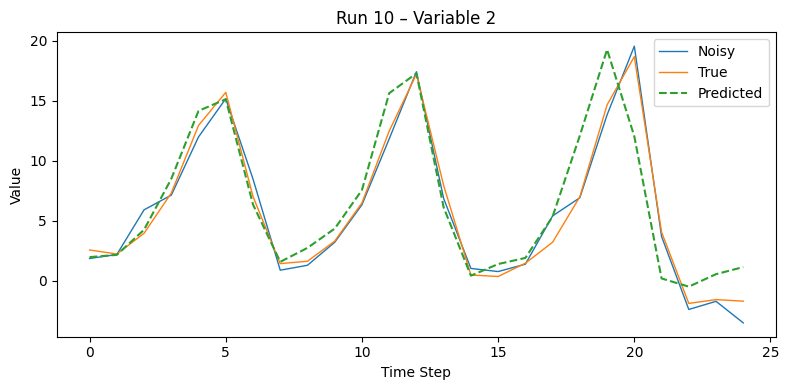

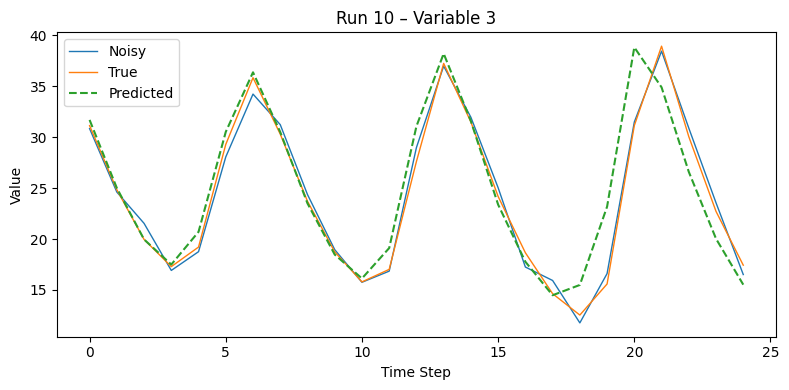

[Adam] Epoch   0 | Loss: 5.0341e+01
[Adam] Epoch 1000 | Loss: 3.7265e-01
[Adam] Epoch 1999 | Loss: 3.0013e-01
[L-BFGS] Epoch   0 | Loss: 2.9849e-01
Early stopping triggered at epoch 84
Final model saved after L-BFGS fine-tuning.


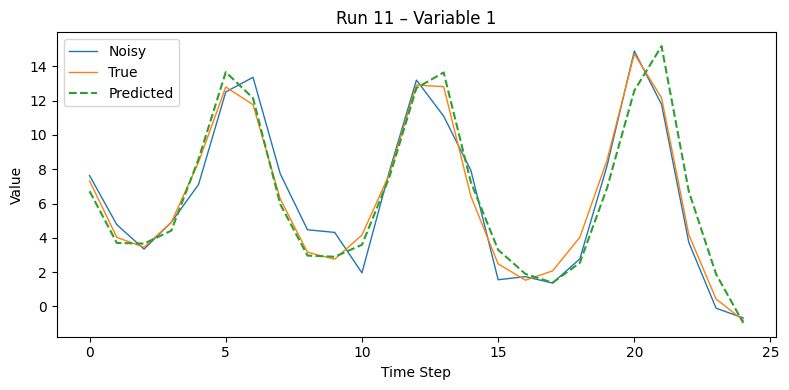

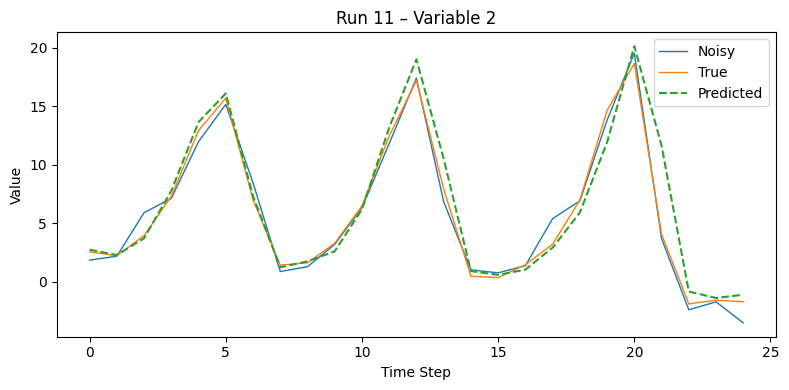

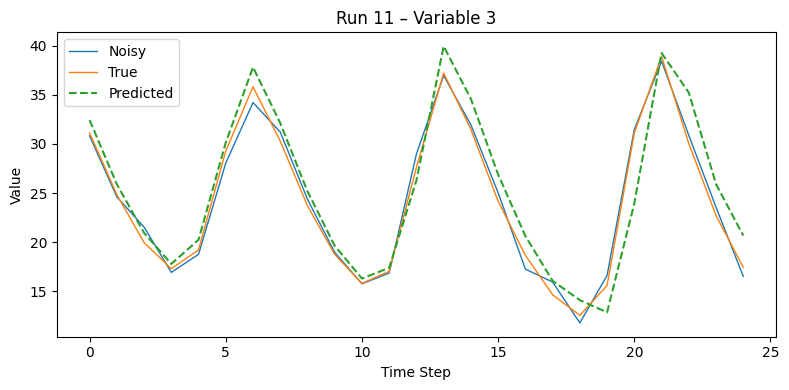

[Adam] Epoch   0 | Loss: 4.0594e+01
[Adam] Epoch 1000 | Loss: 3.6428e-01
[Adam] Epoch 1999 | Loss: 2.7107e-01
[L-BFGS] Epoch   0 | Loss: 2.9488e-01
Early stopping triggered at epoch 70
Final model saved after L-BFGS fine-tuning.


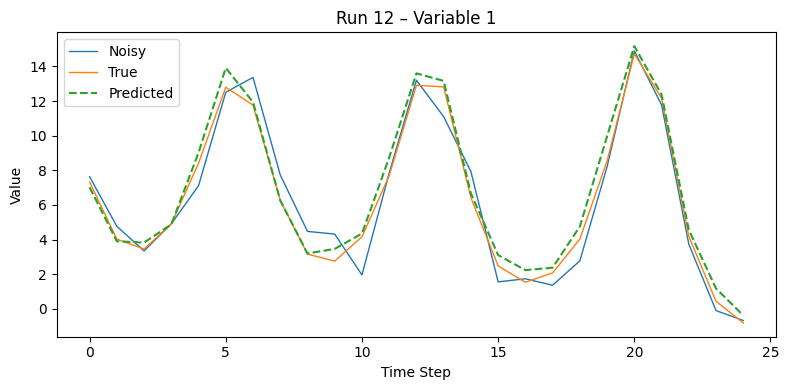

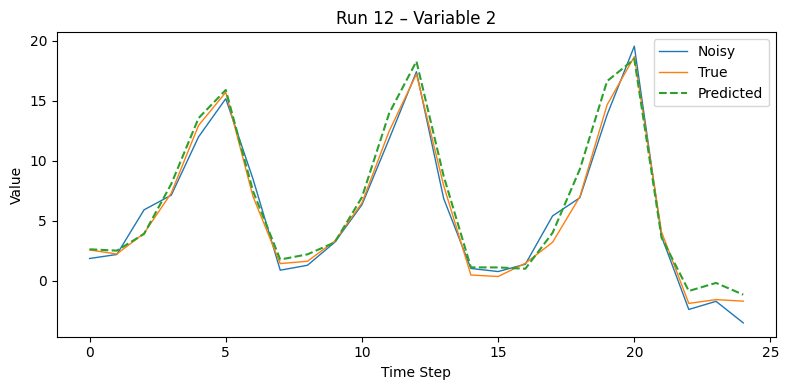

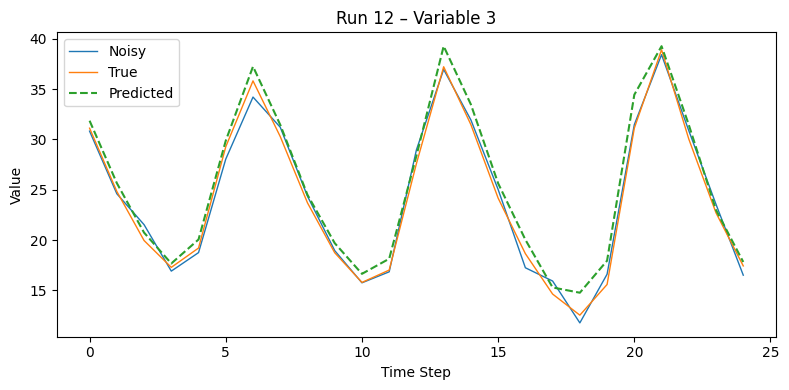

[Adam] Epoch   0 | Loss: 4.5128e+01
[Adam] Epoch 1000 | Loss: 4.5621e-01
[Adam] Epoch 1999 | Loss: 2.9059e-01
[L-BFGS] Epoch   0 | Loss: 3.0791e-01
Early stopping triggered at epoch 96
Final model saved after L-BFGS fine-tuning.


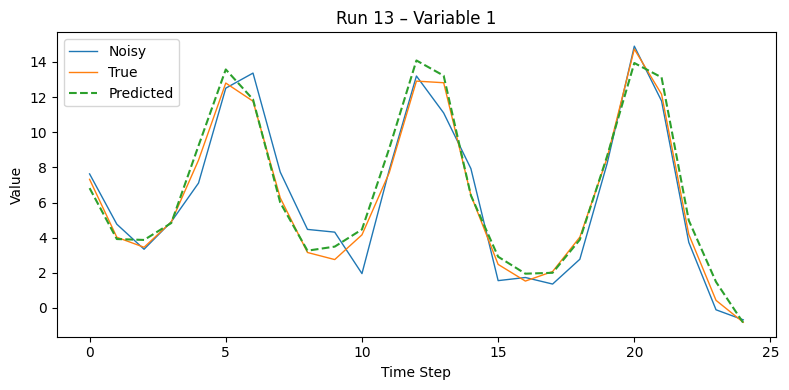

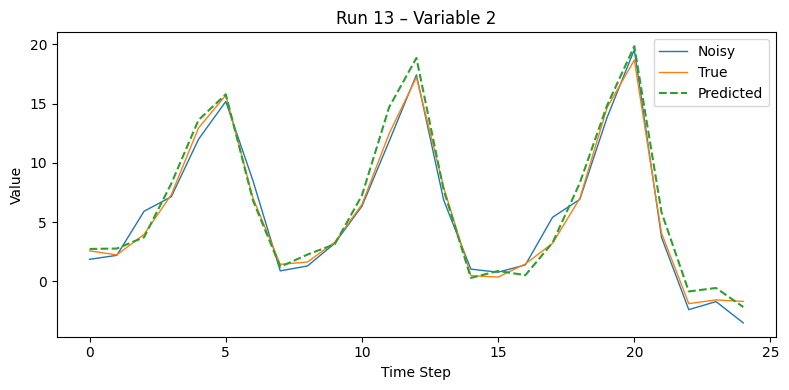

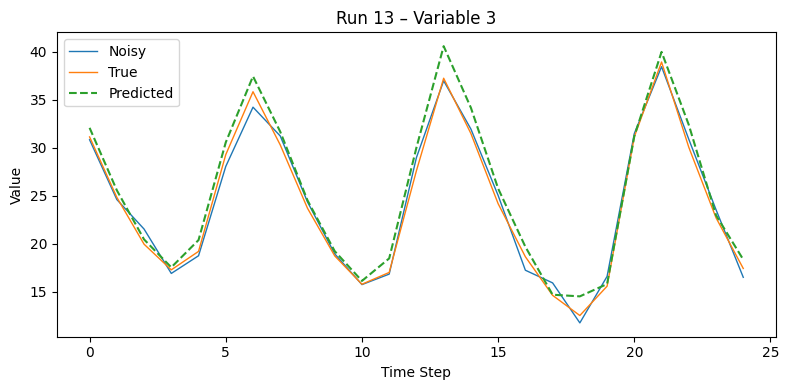

[Adam] Epoch   0 | Loss: 4.1961e+01
[Adam] Epoch 1000 | Loss: 3.5682e-01
[Adam] Epoch 1999 | Loss: 3.1276e-01
[L-BFGS] Epoch   0 | Loss: 2.7504e-01
Early stopping triggered at epoch 81
Final model saved after L-BFGS fine-tuning.


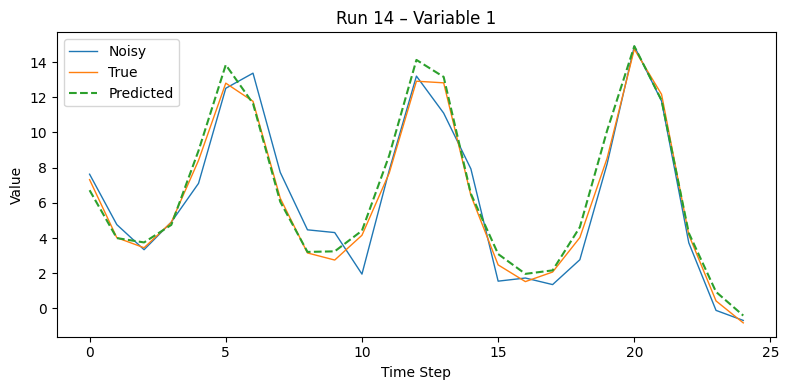

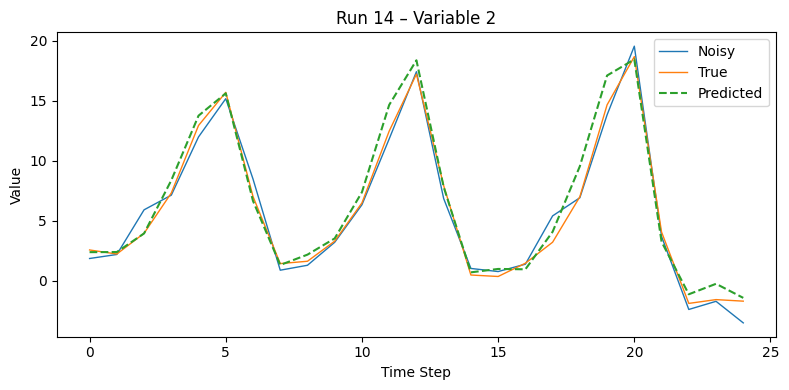

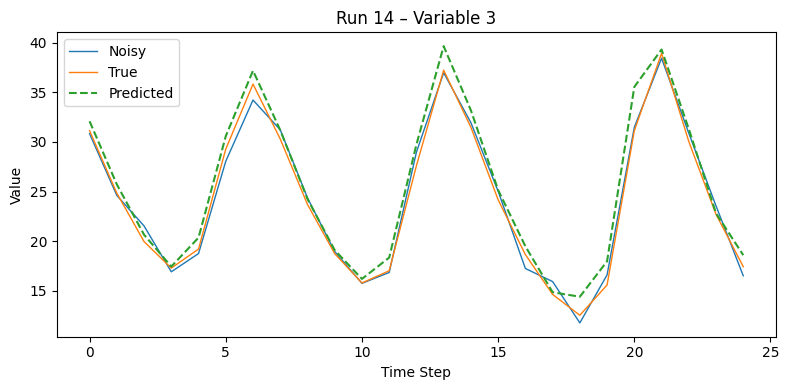

[Adam] Epoch   0 | Loss: 4.2713e+01
[Adam] Epoch 1000 | Loss: 3.8624e-01
[Adam] Epoch 1999 | Loss: 3.3694e-01
[L-BFGS] Epoch   0 | Loss: 2.9125e-01
Early stopping triggered at epoch 92
Final model saved after L-BFGS fine-tuning.


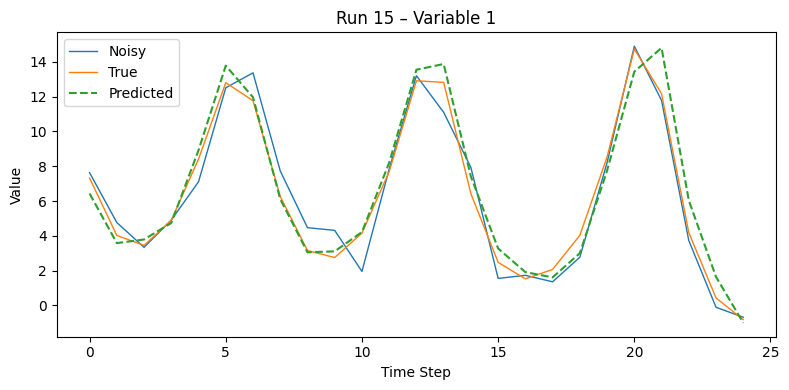

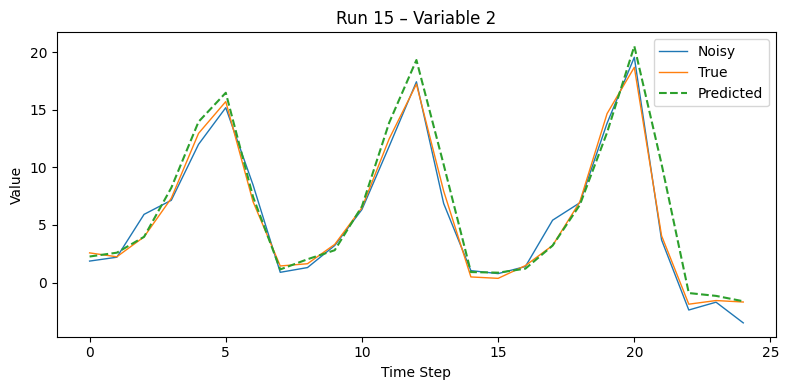

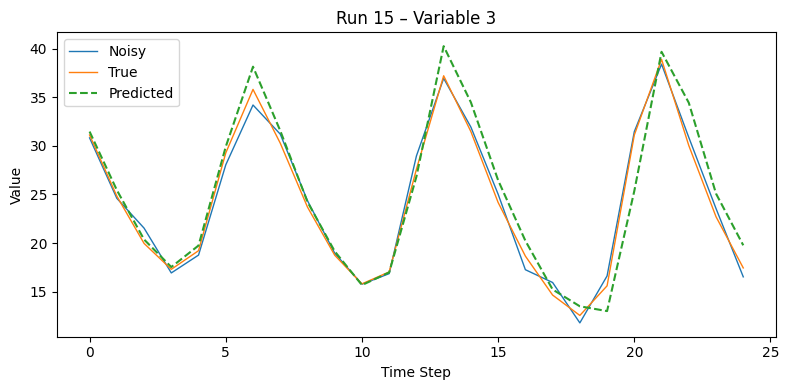

[Adam] Epoch   0 | Loss: 4.2846e+01
[Adam] Epoch 1000 | Loss: 3.8797e-01
[Adam] Epoch 1999 | Loss: 2.8926e-01
[L-BFGS] Epoch   0 | Loss: 3.1910e-01
Early stopping triggered at epoch 98
Final model saved after L-BFGS fine-tuning.


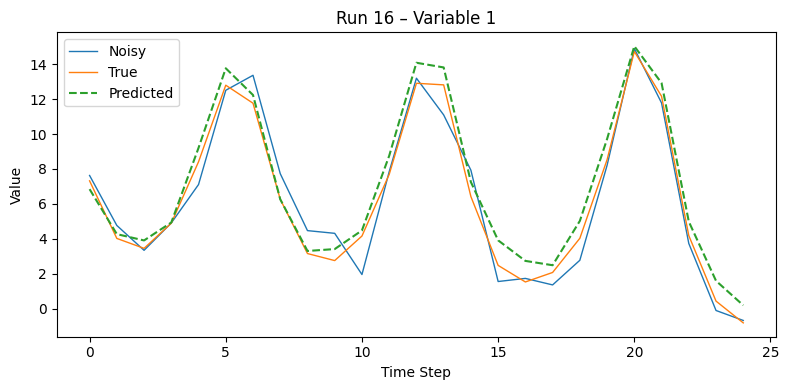

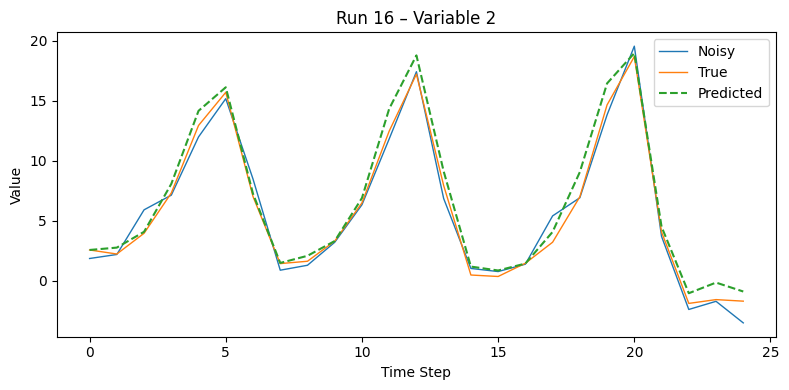

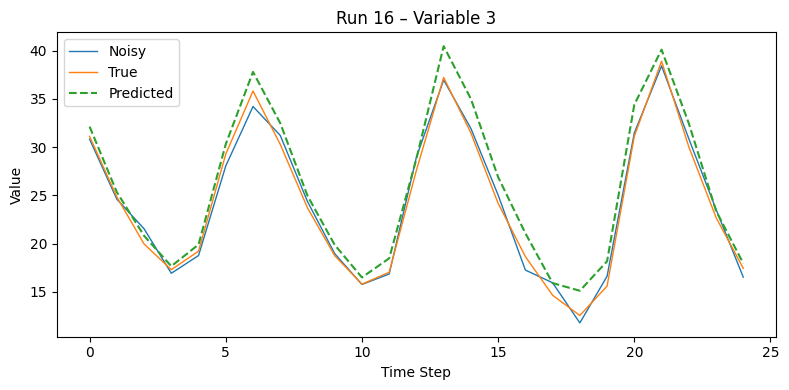

[Adam] Epoch   0 | Loss: 4.8178e+01
[Adam] Epoch 1000 | Loss: 3.8667e-01
[Adam] Epoch 1999 | Loss: 3.4403e-01
[L-BFGS] Epoch   0 | Loss: 2.7976e-01
[L-BFGS] Epoch 100 | Loss: 2.6320e-01
Early stopping triggered at epoch 145
Final model saved after L-BFGS fine-tuning.


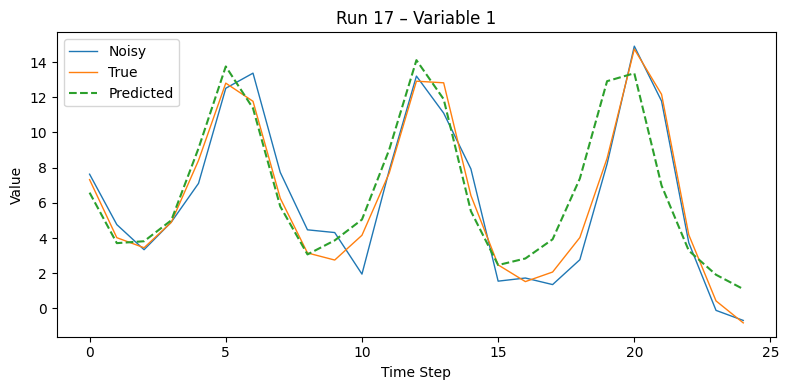

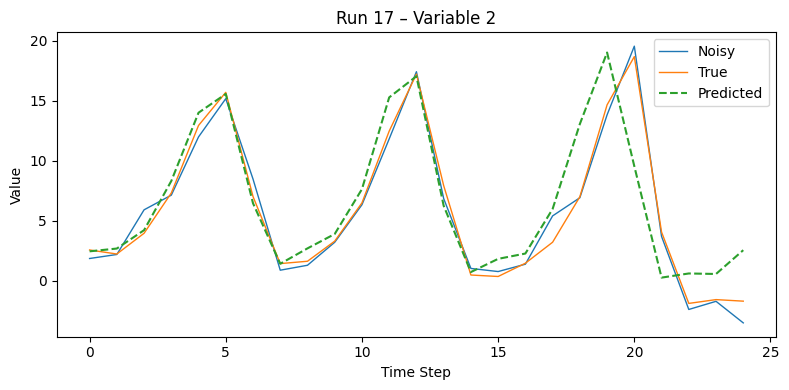

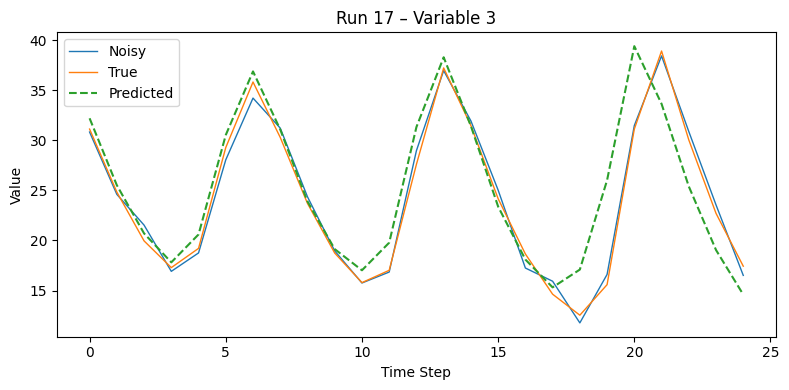

[Adam] Epoch   0 | Loss: 4.2833e+01
[Adam] Epoch 1000 | Loss: 3.8910e-01
[Adam] Epoch 1999 | Loss: 3.2152e-01
[L-BFGS] Epoch   0 | Loss: 2.8857e-01
[L-BFGS] Epoch 100 | Loss: 2.6427e-01
Early stopping triggered at epoch 127
Final model saved after L-BFGS fine-tuning.


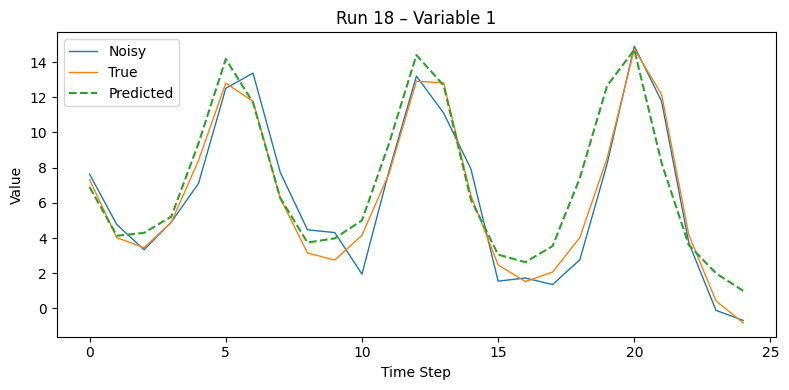

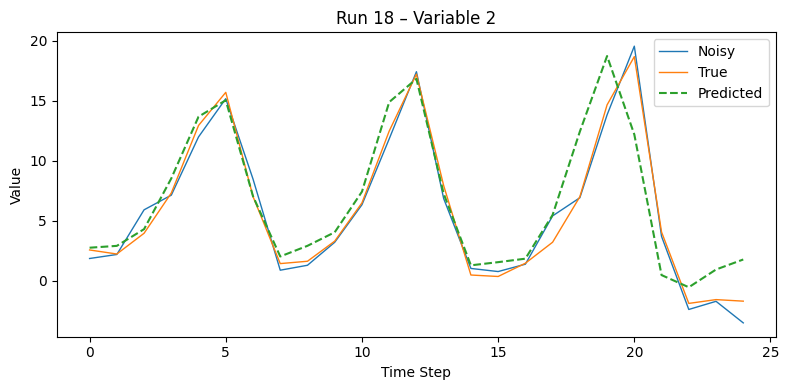

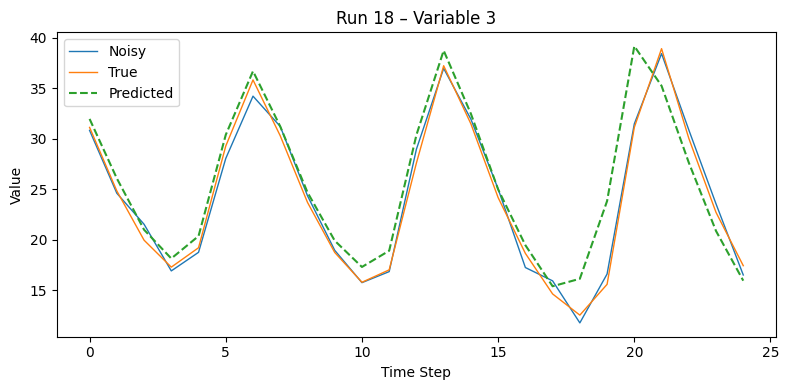

[Adam] Epoch   0 | Loss: 4.2787e+01
[Adam] Epoch 1000 | Loss: 3.6866e-01
[Adam] Epoch 1999 | Loss: 2.9128e-01
[L-BFGS] Epoch   0 | Loss: 2.6772e-01
[L-BFGS] Epoch 100 | Loss: 2.8182e-01
Early stopping triggered at epoch 116
Final model saved after L-BFGS fine-tuning.


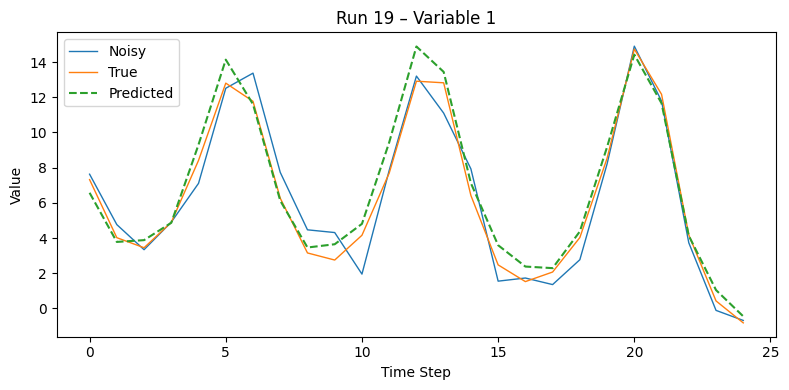

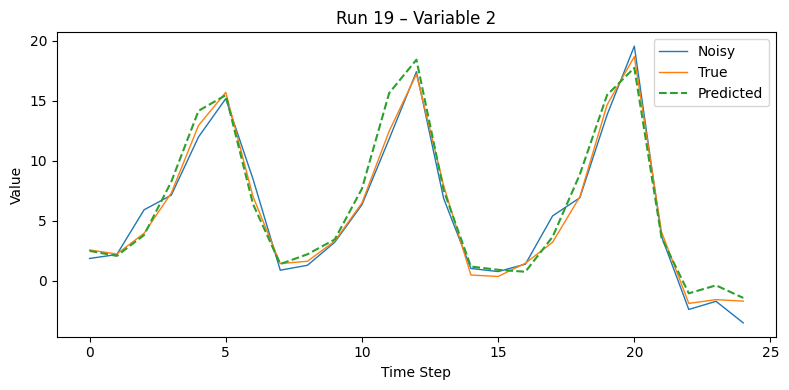

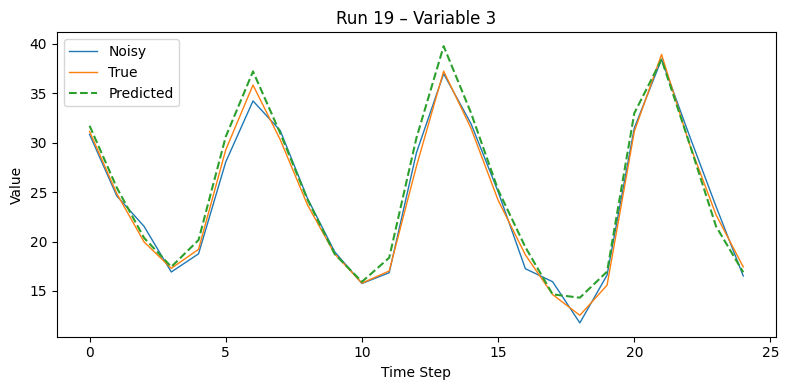

[Adam] Epoch   0 | Loss: 4.4960e+01
[Adam] Epoch 1000 | Loss: 3.8890e-01
[Adam] Epoch 1999 | Loss: 2.7846e-01
[L-BFGS] Epoch   0 | Loss: 3.2105e-01
Early stopping triggered at epoch 91
Final model saved after L-BFGS fine-tuning.


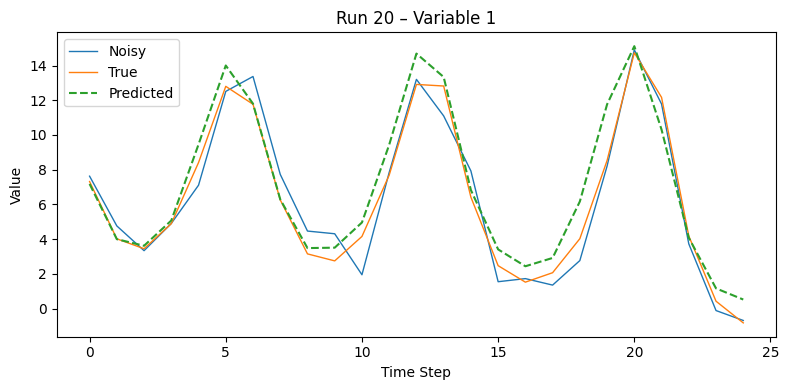

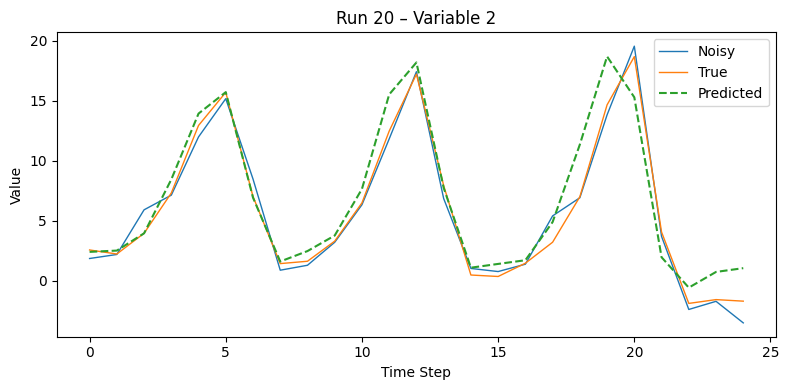

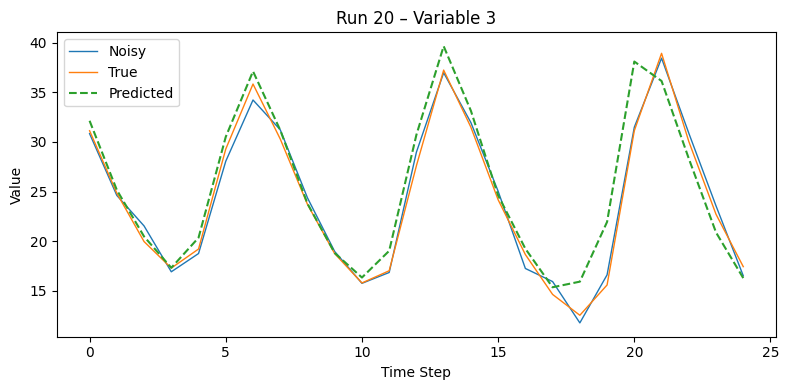

[Adam] Epoch   0 | Loss: 4.8283e+01
[Adam] Epoch 1000 | Loss: 4.2406e-01
[Adam] Epoch 1999 | Loss: 2.8306e-01
[L-BFGS] Epoch   0 | Loss: 2.8217e-01
[L-BFGS] Epoch 100 | Loss: 2.6439e-01
Early stopping triggered at epoch 157
Final model saved after L-BFGS fine-tuning.


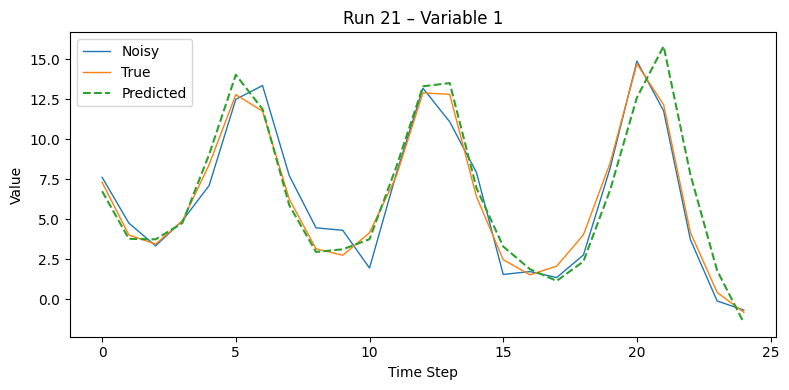

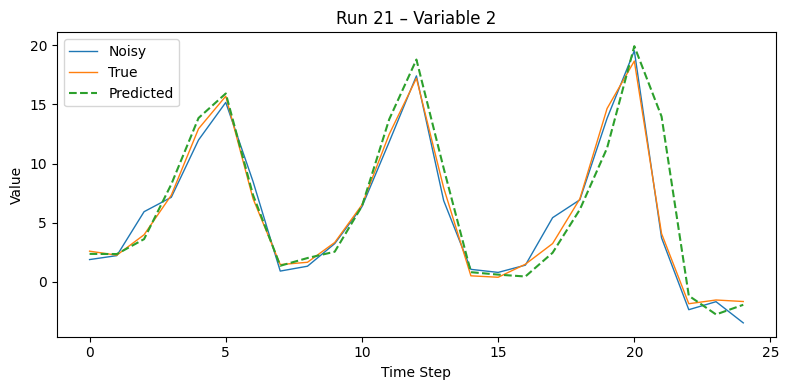

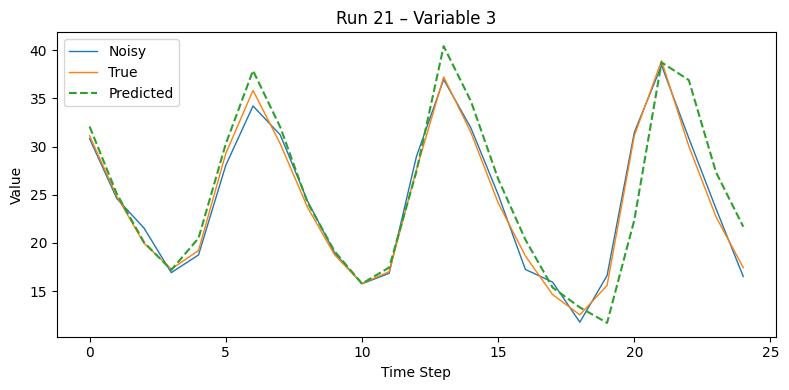

[Adam] Epoch   0 | Loss: 5.2933e+01
[Adam] Epoch 1000 | Loss: 4.2912e-01
[Adam] Epoch 1999 | Loss: 3.0911e-01
[L-BFGS] Epoch   0 | Loss: 2.8836e-01
Early stopping triggered at epoch 74
Final model saved after L-BFGS fine-tuning.


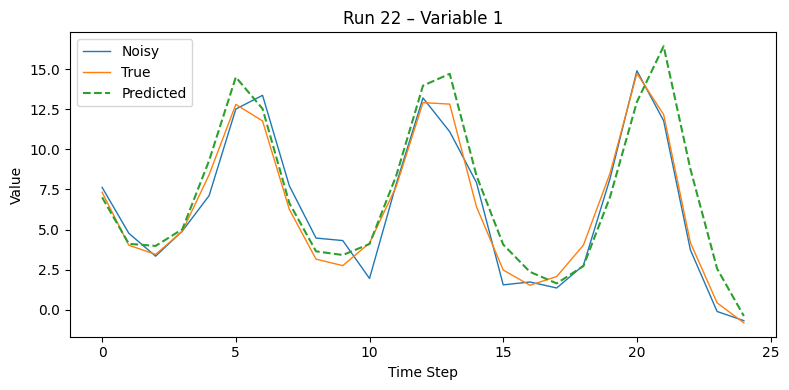

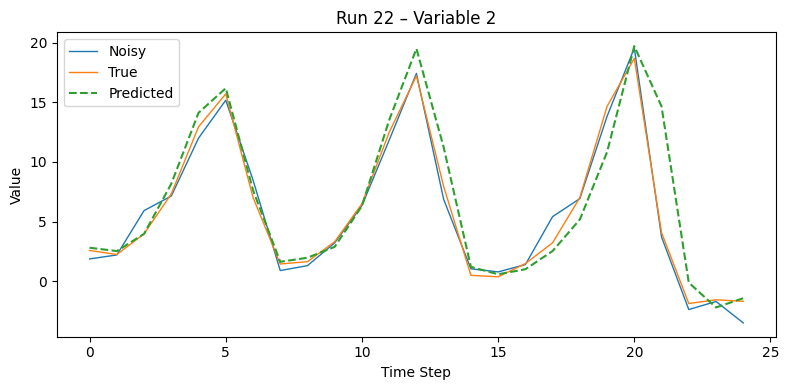

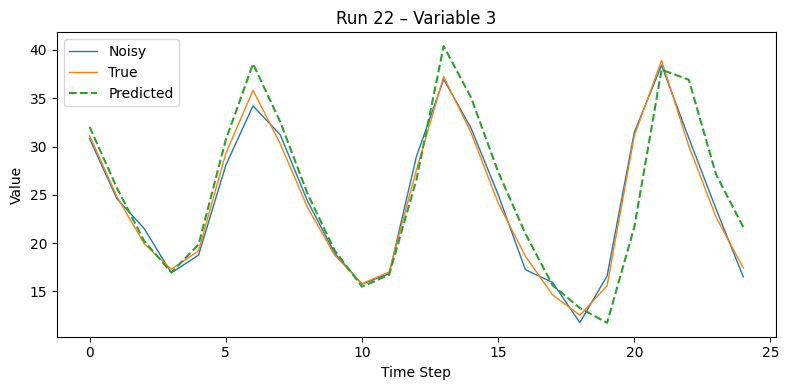

[Adam] Epoch   0 | Loss: 4.5670e+01
[Adam] Epoch 1000 | Loss: 4.2428e-01
[Adam] Epoch 1999 | Loss: 2.8053e-01
[L-BFGS] Epoch   0 | Loss: 2.8665e-01
Early stopping triggered at epoch 64
Final model saved after L-BFGS fine-tuning.


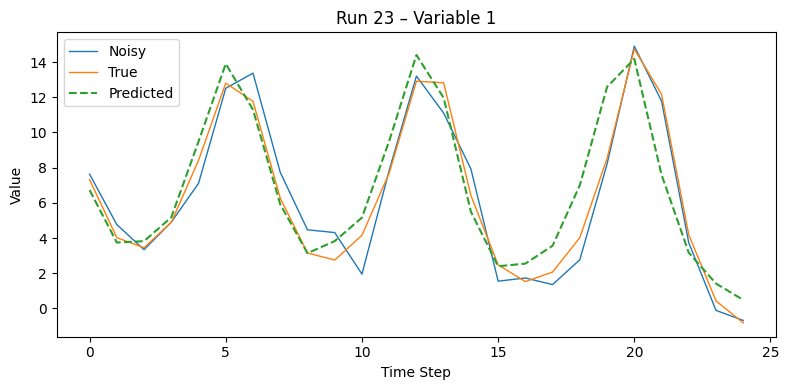

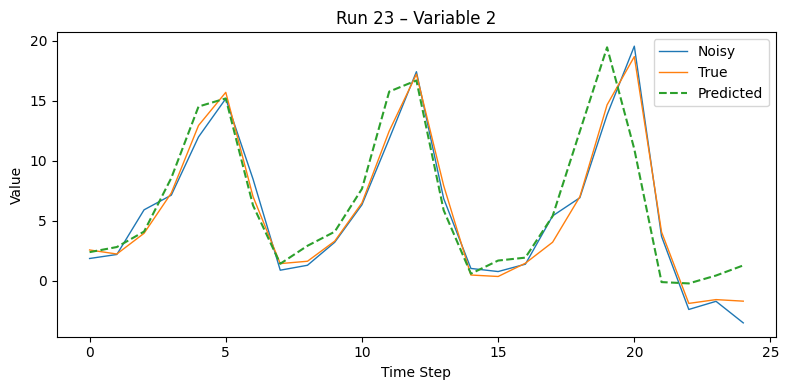

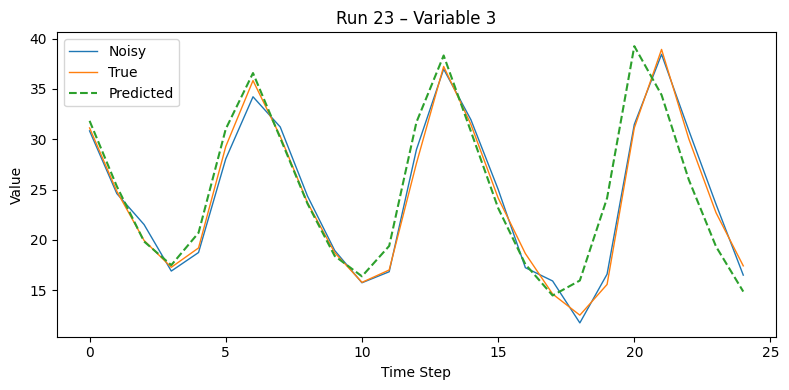

[Adam] Epoch   0 | Loss: 4.0739e+01
[Adam] Epoch 1000 | Loss: 4.4343e-01
[Adam] Epoch 1999 | Loss: 3.1639e-01
[L-BFGS] Epoch   0 | Loss: 2.8725e-01
Early stopping triggered at epoch 85
Final model saved after L-BFGS fine-tuning.


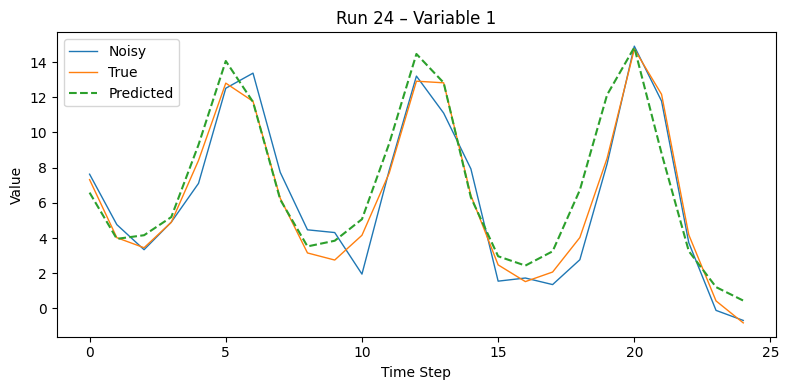

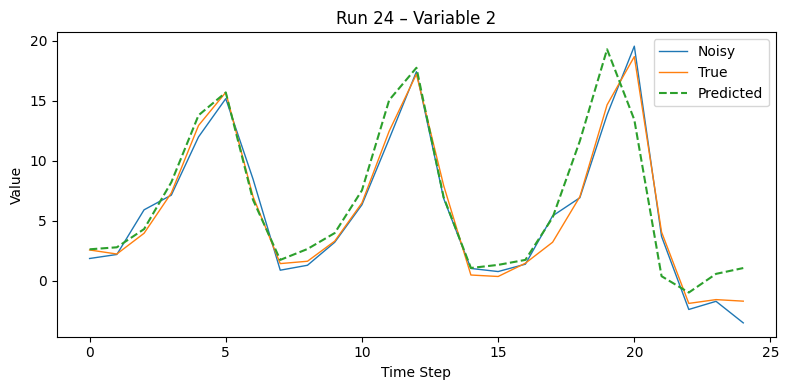

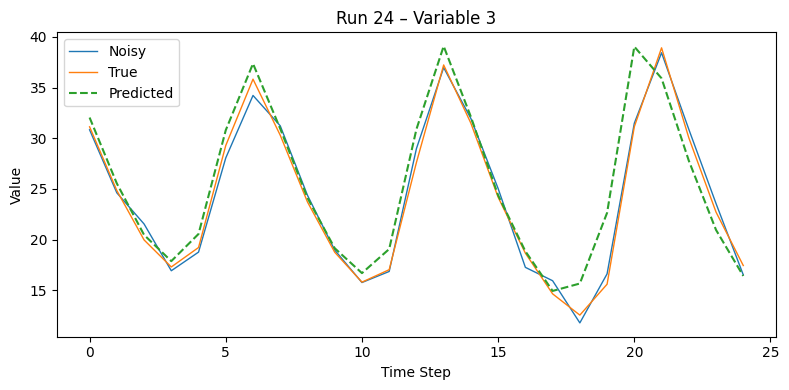

[Adam] Epoch   0 | Loss: 3.8897e+01
[Adam] Epoch 1000 | Loss: 3.7695e-01
[Adam] Epoch 1999 | Loss: 2.9357e-01
[L-BFGS] Epoch   0 | Loss: 2.8432e-01
Early stopping triggered at epoch 90
Final model saved after L-BFGS fine-tuning.


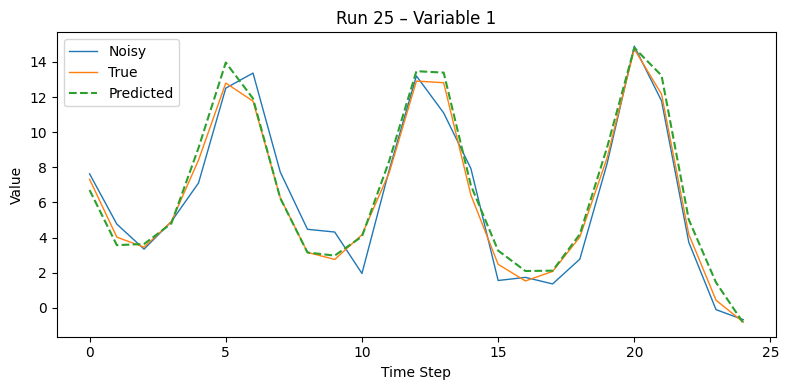

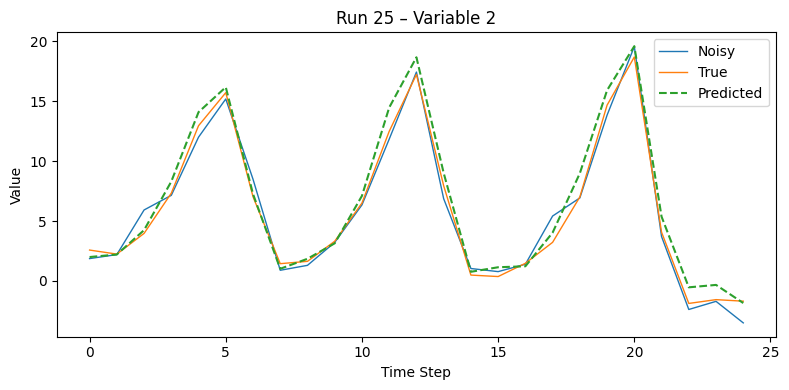

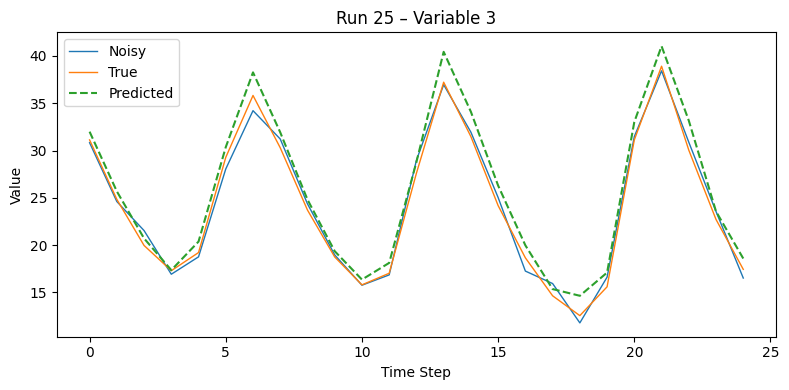


RMSE over 5 time steps:
Variable 1: 0.502102 ± 0.097316
Variable 2: 0.625614 ± 0.151745
Variable 3: 0.763935 ± 0.199901

RMSE over 10 time steps:
Variable 1: 0.583970 ± 0.102814
Variable 2: 0.567098 ± 0.136615
Variable 3: 0.985632 ± 0.199674

RMSE over 15 time steps:
Variable 1: 0.715658 ± 0.173946
Variable 2: 0.923960 ± 0.186971
Variable 3: 1.410294 ± 0.203575

RMSE over 25 time steps:
Variable 1: 1.186119 ± 0.486372
Variable 2: 1.818841 ± 0.835136
Variable 3: 2.397399 ± 0.905390


In [10]:
warnings.filterwarnings("ignore", category=FutureWarning)

base_seed = 2025
num_runs = 25

rmse_runs25 = []
rmse_runs50 = []
rmse_runs75 = []
rmse_runs100 = []

for i in range(num_runs):
    seed = base_seed + i
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    AdaptiveNVARmodel = train_joint_model_with_lbfgs(X_train, k=k, m=m)
    
    model = AdaptiveNVARModel(dk=dk, m=m, d=d).to(device)
    model.load_state_dict(torch.load("best_joint_model_10percent_noise_obs4.pth"))
    model.eval()

    # Prepare test data
    H_test = construct_H_lin(X_test, k)
    y_test = X_test[k:] - X_test[k - 1:-1]

    # Auto-regressive prediction loop
    X_init = X_train[-k:]
    x_t = [x.clone() for x in X_init.unbind(0)]
    H_lin = torch.cat(x_t, dim=-1).unsqueeze(0)
    predictions = []

    num_steps = len(X_test)
    for t in range(num_steps):
        with torch.no_grad():
            delta_x = model(H_lin)
        x_t_next = x_t[-1] + delta_x.squeeze(0)
        predictions.append(x_t_next)
        x_t = x_t[1:] + [x_t_next]
        H_lin = torch.cat(x_t, dim=-1).unsqueeze(0)

    predictions_np = torch.stack(predictions).detach().cpu().numpy()
    X_test_np = X_test.detach().cpu().numpy()
    X_test_true_np = X_test_true.detach().cpu().numpy()

    # ----- PLOTTING SECTION -----
    import matplotlib.pyplot as plt
    X_test_trimmed = X_test_np[:len(predictions_np)]
    X_test_true_trimmed = X_test_true_np[:len(predictions_np)]
    num_vars = predictions_np.shape[1]
    time = np.arange(len(predictions_np))

    for var_idx in range(num_vars):
        plt.figure(figsize=(8, 4))
        plt.plot(time, X_test_trimmed[:, var_idx], label='Noisy', linewidth=1)
        plt.plot(time, X_test_true_trimmed[:, var_idx], label='True', linewidth=1)
        plt.plot(time, predictions_np[:, var_idx], label='Predicted', linestyle='--')
        plt.title(f'Run {i+1} – Variable {var_idx + 1}')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.legend()
        plt.tight_layout()
        plt.show()
    # ----------------------------

    # Compute RMSE for various horizons
    rmse_25 = np.sqrt(np.mean((X_test_true_np[:5] - predictions_np[:5])**2, axis=0))
    rmse_50 = np.sqrt(np.mean((X_test_true_np[:10] - predictions_np[:10])**2, axis=0))
    rmse_75 = np.sqrt(np.mean((X_test_true_np[:15] - predictions_np[:15])**2, axis=0))
    rmse_100 = np.sqrt(np.mean((X_test_true_np[:25] - predictions_np[:25])**2, axis=0))

    rmse_runs25.append(rmse_25)
    rmse_runs50.append(rmse_50)
    rmse_runs75.append(rmse_75)
    rmse_runs100.append(rmse_100)

# --------- Aggregating RMSE ---------
def compute_rmse_stats(rmse_runs):
    arr = np.array(rmse_runs)
    return arr.mean(axis=0), arr.std(axis=0)

rmse_mean25, rmse_std25 = compute_rmse_stats(rmse_runs25)
rmse_mean50, rmse_std50 = compute_rmse_stats(rmse_runs50)
rmse_mean75, rmse_std75 = compute_rmse_stats(rmse_runs75)
rmse_mean100, rmse_std100 = compute_rmse_stats(rmse_runs100)

# ---------- Print RMSE ----------
def print_rmse(label, mean, std):
    print(f"\nRMSE over {label} time steps:")
    for i in range(len(mean)):
        print(f"Variable {i+1}: {mean[i]:.6f} ± {std[i]:.6f}")

print_rmse(5, rmse_mean25, rmse_std25)
print_rmse(10, rmse_mean50, rmse_std50)
print_rmse(15, rmse_mean75, rmse_std75)
print_rmse(25, rmse_mean100, rmse_std100)